In [ ]:
# default_exp modeling.core

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# modeling.core

> This module contains core custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your huggingface models trained via fastai

In [ ]:
#export
import inspect, torch
from transformers import *

from fastai.text.all import *
from fastai.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import *

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1+cu110
Using fastai 2.2.7
Using transformers 4.3.3


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Base splitter, model wrapper, and model callback

In [ ]:
#export
def hf_splitter(m):
    """Splits the huggingface model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]
    
    groups = L([ m for m_name, m in list(top_module.named_children()) ])
    groups += L([ m for m_name, m in root_modules[1:] ])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
show_doc(hf_splitter)

<h4 id="hf_splitter" class="doc_header"><code>hf_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hf_splitter</code>(**`m`**)

Splits the huggingface model based on various model architecture conventions

In [ ]:
#export
class HF_BaseModelWrapper(Module):
    def __init__(self, hf_model, output_hidden_states=False, output_attentions=False, hf_model_kwargs={}):
        super().__init__()
        
        store_attr(self=self, names='output_hidden_states, output_attentions, hf_model_kwargs')
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x): 
        for k in list(x): 
            if k not in self.hf_model_fwd_args: del x[k]

        return self.hf_model(**x,  
                             output_hidden_states=self.output_hidden_states, 
                             output_attentions=self.output_attentions,
                             return_dict=True,
                             **self.hf_model_kwargs)

Note that `HF_BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

In [ ]:
#export
import pdb
class HF_PreCalculatedLoss():
    def __call__(self, inp, targ, **kwargs):return tensor(0.)
    def decodes(self, x): return x.argmax(dim=-1)
    def activation(self, x): return F.softmax(x, dim=-1)

If you want to let your huggingface model calculate the loss for you, make sure you include the `labels` argument in your inputs and use `HF_PreCalculatedLoss` as your loss function. Even though we don't really need a loss function per se, we have to provide a custom loss class/function for fastai to function properly (e.g. one with a `decodes` and `activation` methods).  Why?  Because these methods will get called in methods like `show_results` to get the actual predictions.

In [ ]:
#export
class HF_BaseModelCallback(Callback):

    def before_batch(self): self.hf_loss = None
        
    def after_pred(self): 
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}
        
        for k,v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if (k == 'loss' and isinstance(self.learn.loss_func, HF_PreCalculatedLoss)): 
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif (k == 'logits'):
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v
            
    def after_loss(self): 
        # if we already have the loss from the model, update the Learner's loss to be it
        if (self.hf_loss is not None): 
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling what is returned from the huggingface model. The return type is (`ModelOutput`)[https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput] which makes it easy to return all the goodies we asked for.

Note that your `Learner`'s loss will be set for you only if the huggingface model returns one *and* you are using the `HF_PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `HF_BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Sequence classification

Below demonstrates how to setup your `blurr` pipeline for a sequence classification task (e.g., a model that requires a single text input)

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
imdb_df = pd.read_csv(path/'texts.csv')

In [ ]:
imdb_df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
#hide_output
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, task=task)

In [ ]:
# single input
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader('label'), splitter=ColSplitter())

In [ ]:
# dblock.summary(imdb_df)

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,category
0,"Raising Victor Vargas: A Review<br /><br />You know, Raising Victor Vargas is like sticking your hands into a big, steaming bowl of oatmeal. It's warm and gooey, but you're not sure if it feels right. Try as I might, no matter how warm and gooey Raising Victor Vargas became I was always aware that something didn't quite feel right. Victor Vargas suffers from a certain overconfidence on the director's part. Apparently, the director thought that the ethnic backdrop of a Latino family on the lower east side, and an idyllic storyline would make the film critic proof. He was right, but it didn't fool me. Raising Victor Vargas is the story about a seventeen-year old boy called, you guessed it, Victor Vargas (Victor Rasuk) who lives his teenage years chasing more skirt than the Rolling Stones could do in all the years they've toured. The movie starts off in `Ugly Fat' Donna's bedroom where Victor is sure to seduce her, but a cry from outside disrupts his plans when his best-friend Harold (Kevin Rivera) comes-a-looking for him. Caught in the attempt by Harold and his sister, Victor Vargas runs off for damage control. Yet even with the embarrassing implication that he's been boffing the homeliest girl in the neighborhood, nothing dissuades young Victor from going off on the hunt for more fresh meat. On a hot, New York City day they make way to the local public swimming pool where Victor's eyes catch a glimpse of the lovely young nymph Judy (Judy Marte), who's not just pretty, but a strong and independent too. The relationship that develops between Victor and Judy becomes the focus of the film. The story also focuses on Victor's family that is comprised of his grandmother or abuelita (Altagracia Guzman), his brother Nino (also played by real life brother to Victor, Silvestre Rasuk) and his sister Vicky (Krystal Rodriguez). The action follows Victor between scenes with Judy and scenes with his family. Victor tries to cope with being an oversexed pimp-daddy, his feelings for Judy and his grandmother's conservative Catholic upbringing.<br /><br />The problems that arise from Raising Victor Vargas are a few, but glaring errors. Throughout the film you get to know certain characters like Vicky, Nino, Grandma,",negative
1,"""Look, I know this may suck right now, but pain is temporary, film is forever. Whatever you do right now is burned into celluloid for all time and for thousands of years to come.""  Robert De Niro<br /><br />This was initially a film for Steven Spielberg, the director hiring several screenwriters to adjust the screenplay so that it more suited his themes. And so we have a dysfunctional family that is threatened by a deranged monster in the form of a recently released from prison Robert De Niro. Like ""Jurassic Park"", ""Poltergeist"" and ""War of the Worlds"", the dysfunctional family bands together to defeat the beast, the beast being the creation of the father, a lawyer who failed to defend De Niro during his trial. <br /><br />In typical Spielberg fashion, the father kills the monster that undermines the family and is then promptly absolved of his sins. Like Oscar Schindler, Robin Williams, Sam Niel, Tom Cruise and virtually every ""daddy"" figure in Spielberg land, the father reclaims his paternal duty in the kind of bittersweet coda that Spielberg so enjoys.<br /><br />But Spielberg eventually abandoned the picture and the project was instead turned over to Martin Scorsese, who at the time was seeking to try his hand at more commercial fare. The result is arguably the worst film in Scorsese's filmography, and, ironically, his most illuminating.<br /><br />An artist's failures or misfires are often very revealing, exposing the inner workings of their art. When the story doesn't work, the characters don't connect or the images don't sear, we find ourselves left with a kind of inner core. This  the remaining carcass- is what the director's cinema is about.<br /><br />Now ""Cape Fear"" is an impersonal

### Training

We'll also add in custom summary methods for blurr learners/models that work with dictionary inputs

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

`.to_fp16()` requires a GPU so had to remove for tests to run on github.  Let's check that we can get predictions.

In [ ]:
b = dls.one_batch()

In [ ]:
learn.model(b[0])

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0256,  0.0222],
        [-0.0134,  0.0345],
        [-0.0102,  0.0349],
        [-0.0116,  0.0233]], device='cuda:1', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [ ]:
#export
def blurr_module_summary(learn, *xb):
    "Print a summary of `model` using `xb`"
    #Individual parameters wrapped in ParameterModule aren't called through the hooks in `layer_info`,
    #  thus are not counted inside the summary
    #TODO: find a way to have them counted in param number somehow
    infos = layer_info(learn, *xb)
    n,bs = 76,find_bs(xb)
    inp_sz = _print_shapes(apply(lambda x:x.shape,  xb[0]['input_ids']), bs)
    res = f"{type(learn.model).__name__} (Input shape: {inp_sz})\n"
    res += "=" * n + "\n"
    res += f"{'Layer (type)':<20} {'Output Shape':<20} {'Param #':<10} {'Trainable':<10}\n"
    res += "=" * n
    ps,trn_ps,j = 0,0,0
    infos = [o for o in infos if o is not None] #see comment in previous cell
    prev_sz = None
    for typ,np,trn,sz,chnged in infos:
        if sz is None: continue
        if j == 0:
            res += f'\n{"":<20} {_print_shapes(sz, bs)[:19]:<20}' # to avoid a double line at the top
        if not chnged and not prev_sz == sz and j > 0: res += "\n" + "_" * n + "\n" + f'{"":<20} {_print_shapes(sz, bs)[:19]:<20}'
        j = 1
        res += f"\n{typ:<20} {'':<20} {np:<10} {str(trn):<10}"
        if np is not '':
            ps += np
            if trn: trn_ps += np
        prev_sz = sz
    res += "\n" + "_" * n + "\n"
    res += f"\nTotal params: {ps:,}\n"
    res += f"Total trainable params: {trn_ps:,}\n"
    res += f"Total non-trainable params: {ps - trn_ps:,}\n\n"
    return PrettyString(res)

In [ ]:
#export
@patch
def blurr_summary(self:Learner):
    "Print a summary of the model, optimizer and loss function."
    xb = self.dls.train.one_batch()[:self.dls.train.n_inp]
    res = blurr_module_summary(self, *xb)
    res += f"Optimizer used: {self.opt_func}\nLoss function: {self.loss_func}\n\n"
    if self.opt is not None:
        res += f"Model " + ("unfrozen\n\n" if self.opt.frozen_idx==0 else f"frozen up to parameter group #{self.opt.frozen_idx}\n\n")
    res += "Callbacks:\n" + '\n'.join(f"  - {cb}" for cb in sort_by_run(self.cbs))
    return PrettyString(res)

We have to create our own `summary` methods above because fastai only works where things are represented by a *single tensor*.  But in the case of huggingface transformers, a *single* sequence is represented by *multiple tensors* (in a dictionary).  

The change to make this work is so minor I think that the fastai library can/will hopefully be updated to support this use case.

In [ ]:
# learn.blurr_summary()

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=0.033113110810518265)

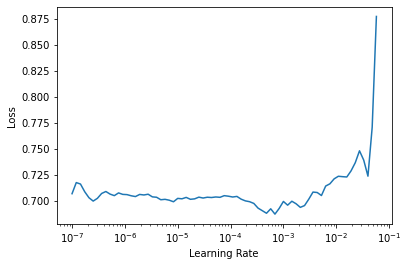

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.341195,0.267415,0.920000,00:21


### Showing results

And here we creat a @typedispatched impelmentation of `Learner.show_results`.

In [ ]:
#export
@typedispatch
def show_results(x:HF_BaseInput, y, samples, outs, learner, ctxs=None, max_n=6, trunc_at=None, **kwargs):    
    #grab tokenizer and trunc_at to pass into HF_BaseInput.show
    hf_before_batch_tfm = get_blurr_tfm(learner.dls.before_batch)
    kwargs['hf_tokenizer'] = hf_before_batch_tfm.hf_tokenizer
    kwargs['trunc_at'] = trunc_at
    
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)
    
    n_preds_per_input = len(outs[0])
    if (n_preds_per_input == 1): 
        for i,ctx in enumerate(ctxs): ctx['target'] = outs[i][0]
    else:
        for pred_idx in range(n_preds_per_input):
            for i,ctx in enumerate(ctxs):  ctx[f'target{pred_idx+1}'] = outs[i][pred_idx]

    display_df(pd.DataFrame(ctxs))
    return ctxs

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geish",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I have not read Hickam's memoirs, but I am still able to enjoy and understand their film adaptation. The film, directed by Joe Johnston and written by Lewis Colick, records the story of teenager Homer Hickam (Jake Gyllenhaal), beginning in October of 195",positive,positive


In [ ]:
#export
@patch
def blurr_predict(self:Learner, items, rm_type_tfms=None):
    hf_before_batch_tfm = get_blurr_tfm(self.dls.before_batch)
    
    is_split_str = hf_before_batch_tfm.is_split_into_words and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)
    
    if (not is_df and (is_split_str or not is_listy(items))): items = [items]
    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)
    
    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp:]
    
    outs = []
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])
        
        outs.append((item_dec_labels, item_dec_preds, item_probs))
    
    return outs

Same as with `summary`, we need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
learn.blurr_predict('I really liked the movie')

[(('positive',), (#1) [tensor(1)], (#1) [tensor([0.2454, 0.7546])])]

In [ ]:
learn.blurr_predict(['I really liked the movie', 'I really hated the movie'])

[(('positive',), (#1) [tensor(1)], (#1) [tensor([0.2454, 0.7546])]),
 (('negative',), (#1) [tensor(0)], (#1) [tensor([0.7410, 0.2590])])]

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.245647,0.245074,0.900000,00:34
1,0.193117,0.238627,0.920000,00:34
2,0.143660,0.249063,0.920000,00:34


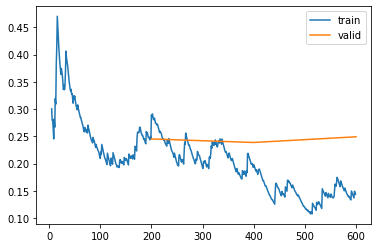

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geish",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I have not read Hickam's memoirs, but I am still able to enjoy and understand their film adaptation. The film, directed by Joe Johnston and written by Lewis Colick, records the story of teenager Homer Hickam (Jake Gyllenhaal), beginning in October of 195",positive,positive


In [ ]:
learn.blurr_predict("This was a really good movie")

[(('positive',), (#1) [tensor(1)], (#1) [tensor([0.1194, 0.8806])])]

In [ ]:
learn.blurr_predict("Acting was so bad it was almost funny.")

[(('negative',), (#1) [tensor(0)], (#1) [tensor([0.9599, 0.0401])])]

### Inference

In [ ]:
export_fname = 'seq_class_learn_export'

#### Using fast.ai `Learner.export` and `load_learner`

In [ ]:
learn.export(fname=f'{export_fname}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")

[(('negative',), (#1) [tensor(0)], (#1) [tensor([0.9216, 0.0784])])]

#### Using ONNX

Much of the inspiration for the code below comes from Zach Mueller's excellent [fastinference library](https://muellerzr.github.io/fastinference/), and in many places I simply adapted his code to work with blurr and the various huggingface transformers tasks.

In [ ]:
# #export
# import onnxruntime as ort
# from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
# #export
# @patch
# def blurr_to_onnx(self:Learner, fname='export', path=None, quantize=False, excluded_input_names=[]):
#     """Export model to `ONNX` format"""
#     if (path == None): path = self.path
        
#     dummy_b = self.dls.one_batch()    
    
#     # inputs
#     for n in excluded_input_names:
#         if (n in dummy_b[0]): del dummy_b[0][n]
            
#     input_names = list(dummy_b[0].keys())
#     dynamic_axes = { n: {0:'batch_size', 1:'sequence'} for n in input_names if n in self.model.hf_model_fwd_args}
    
#     # outputs
#     output_names = [ f'output_{i}' for i in range(len(dummy_b) - self.dls.n_inp) ]
#     for n in output_names: dynamic_axes[n] = { 0:'batch_size' }
    
#     torch.onnx.export(model=self.model, 
#                       args=dummy_b[:self.dls.n_inp],    # everything but the targets
#                       f=self.path/f'{fname}.onnx',      # onnx filename
#                       opset_version=11,                 # required for get errors
#                       input_names=input_names,          # transformer dictionary keys for input
#                       output_names=output_names,        # one for each target
#                       dynamic_axes=dynamic_axes)        # see above
    
#     if (quantize):
#         quant_model_fpath = self.path/f'{fname}-quant.onnx'
#         quant_model = quantize_dynamic(self.path/f'{fname}.onnx', quant_model_fpath, weight_type=QuantType.QUInt8)

#     dls_export = self.dls.new_empty()
#     dls_export.loss_func = self.loss_func
#     dls_export.hf_model_fwd_args = self.model.hf_model_fwd_args # we need this to exclude non-model args in onnx
    
#     torch.save(dls_export, self.path/f'{fname}-dls.pkl', pickle_protocol=2)

In [ ]:
# #slow
# learn.blurr_to_onnx(export_fname, quantize=True)

In [ ]:
# #export
# class blurrONNX():
#     def __init__(self, fname='export', path=Path('.'), use_quant_version=False): 
#         self.fname, self.path = fname, path
        
#         onnx_fname = f'{fname}-quant.onnx' if (use_quant_version) else f'{fname}.onnx'
#         self.ort_session = ort.InferenceSession(str(self.path/onnx_fname))
        
#         self.dls = torch.load(f'{self.path}/{fname}-dls.pkl')
#         self.trg_tfms = self.dls.tfms[self.dls.n_inp:]
#         self.tok_is_split_into_words = self.dls.before_batch[0].is_split_into_words
#         self.hf_model_fwd_args = self.dls.hf_model_fwd_args
        
#     def predict(self, items, rm_type_tfms=None):
#         is_split_str = self.tok_is_split_into_words and isinstance(items[0], str)
#         is_df = isinstance(items, pd.DataFrame)

#         if (not is_df and (is_split_str or not is_listy(items))): items = [items]
#         dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

#         outs = []
#         for b in dl:
#             xb = b[0]
#             inp = self._to_np(xb)
            
#             # remove any args not found in the transformers forward func
#             for k in list(inp.keys()):
#                 if (k not in self.hf_model_fwd_args): del inp[k]
                    
#             res = self.ort_session.run(None, inp)
#             tensor_res = [ tensor(r) for r in res ]
#             probs = L([ self.dls.loss_func.activation(tr) for tr in tensor_res ])
#             decoded_preds = L([ self.dls.loss_func.decodes(tr) for tr in tensor_res ])

#             for i in range(len(xb['input_ids'])):
#                 item_probs = probs.itemgot(i)
#                 item_dec_preds = decoded_preds.itemgot(i)
#                 item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) 
#                                            for tfm_idx, tfm in enumerate(self.trg_tfms)])

#                 outs.append((item_dec_labels, item_dec_preds, item_probs))
            
#         return outs

#     #----- utility -----
#     def _to_np(self, xb): return { k: v.cpu().numpy() for k,v in xb.items() }

In [ ]:
# #slow
# onnx_inf = blurrONNX(export_fname)

In [ ]:
# #slow
# onnx_inf.predict(['I really liked the movie'])

In [ ]:
# #slow
# %timeit inf_learn.blurr_predict(['I really liked the movie', 'I hated everything in it'])
# %timeit onnx_inf.predict(['I really liked the movie', 'I hated everything in it'])

In [ ]:
# #slow
# onnx_inf = blurrONNX(export_fname, use_quant_version=True)
# onnx_inf.predict(['I hated everything in it'])

In [ ]:
# #slow
# %timeit inf_learn.blurr_predict(['I really liked the movie', 'I hated everything in it'])
# %timeit onnx_inf.predict(['I really liked the movie', 'I hated everything in it'])

## Tests

The tests below to ensure the core training code above works for **all** pretrained sequence classification models available in huggingface.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
[ model_type for model_type in BLURR_MODEL_HELPER.get_models(task='SequenceClassification') 
 if (not model_type.__name__.startswith('TF')) ]

[transformers.models.albert.modeling_albert.AlbertForSequenceClassification,
 transformers.models.auto.modeling_auto.AutoModelForSequenceClassification,
 transformers.models.bart.modeling_bart.BartForSequenceClassification,
 transformers.models.bert.modeling_bert.BertForSequenceClassification,
 transformers.models.ctrl.modeling_ctrl.CTRLForSequenceClassification,
 transformers.models.camembert.modeling_camembert.CamembertForSequenceClassification,
 transformers.models.convbert.modeling_convbert.ConvBertForSequenceClassification,
 transformers.models.deberta.modeling_deberta.DebertaForSequenceClassification,
 transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification,
 transformers.models.electra.modeling_electra.ElectraForSequenceClassification,
 transformers.models.flaubert.modeling_flaubert.FlaubertForSequenceClassification,
 transformers.models.funnel.modeling_funnel.FunnelForSequenceClassification,
 transformers.models.gpt2.modeling_gpt2.GPT2ForSequenceC

In [ ]:
pretrained_model_names = [
    'albert-base-v1',
    'facebook/bart-base',
    'bert-base-uncased',
    'sshleifer/tiny-ctrl',
    'camembert-base',
    'microsoft/deberta-base',
    'distilbert-base-uncased',
    'monologg/electra-small-finetuned-imdb',
    'flaubert/flaubert_small_cased', 
    'huggingface/funnel-small-base',
    'gpt2',
    'allenai/led-base-16384',
    'allenai/longformer-base-4096',
    'sshleifer/tiny-mbart', 
    'microsoft/mpnet-base',
    'google/mobilebert-uncased',
    'openai-gpt',
    #'reformer-enwik8',                  (see model card; does not work with/require a tokenizer so no bueno here)
    'roberta-base',
    'squeezebert/squeezebert-uncased',
    #'google/tapas-base',                (requires pip install torch-scatter)
    'transfo-xl-wt103', 
    'xlm-mlm-en-2048',
    'xlm-roberta-base',
    'xlnet-base-cased'
]

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)

model_path = Path('models')
imdb_df = pd.read_csv(path/'texts.csv')

In [ ]:
#slow
#hide_output
task = HF_TASKS_AUTO.SequenceClassification
bsz = 2
seq_sz = 128

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(model_name, 
                                                                                   task=task, 
                                                                                   config_kwargs={'num_labels': 2})
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n')

    # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
    if (hf_tokenizer.pad_token is None): 
        hf_tokenizer.add_special_tokens({'pad_token': '<pad>'})  
        hf_config.pad_token_id = hf_tokenizer.get_vocab()['<pad>']
        hf_model.resize_token_embeddings(len(hf_tokenizer))
                    
    blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=seq_sz, padding='max_length'), 
              CategoryBlock)

    dblock = DataBlock(blocks=blocks, 
                       get_x=ColReader('text'), 
                       get_y=ColReader('label'), 
                       splitter=ColSplitter(col='is_valid'))
    
    dls = dblock.dataloaders(imdb_df, bs=bsz)
    
    model = HF_BaseModelWrapper(hf_model)
    learn = Learner(dls, 
                    model,
                    opt_func=partial(Adam),
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy],
                    cbs=[HF_BaseModelCallback],
                    splitter=hf_splitter).to_fp16()

    learn.create_opt()             # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    b = dls.one_batch()
    
    try:
        print('*** TESTING DataLoaders ***')
        test_eq(len(b), bsz)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, seq_sz]))
        test_eq(len(b[1]), bsz)

#         print('*** TESTING One pass through the model ***')
#         preds = learn.model(b[0])
#         test_eq(len(preds[0]), bsz)
#         test_eq(preds[0].shape, torch.Size([bsz, 2]))

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max=1e-3)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== albert-base-v1 ===

architecture:	albert
tokenizer:	AlbertTokenizerFast
model:		AlbertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.669042,0.641129,0.655000,00:18


,text,category,target
0,"the trouble with the book, ""memoirs of a geisha"" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes ye",negative,positive
1,"we saw the silent version of this film, and it is quite simply shimmeringly beautiful. it's quite hard to see how a sound version could have been created, since it is shot with pure silent technique, long wordless sweeps of narrative without a single",positive,negative


=== facebook/bart-base ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.467646,0.408083,0.810000,00:27


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes y",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I ha",positive,positive


=== bert-base-uncased ===

architecture:	bert
tokenizer:	BertTokenizerFast
model:		BertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.641974,0.633172,0.665000,00:22


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,negative
1,"bonanza had a great cast of wonderful actors. lorne greene, pernell whitaker, michael landon, dan blocker, and even guy williams ( as the cousin who was brought in for several episodes during 1964 to replace adam when he was leaving the series ). the",positive,positive


=== sshleifer/tiny-ctrl ===



Using pad_token, but it is not set yet.


architecture:	ctrl
tokenizer:	CTRLTokenizer
model:		CTRLForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.694807,0.692659,0.510000,00:08


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes ye",negative,negative
1,"Bonanza had a great cast of wonderful actors. Lorne Greene, Pernell Whitaker, Michael Landon, Dan Blocker, and even Guy Williams (as the cousin who was brought in for several episodes during 1964 to replace Adam when he was leaving the series). The c",positive,negative


=== camembert-base ===

architecture:	camembert
tokenizer:	CamembertTokenizerFast
model:		CamembertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.699291,0.688514,0.540000,00:23


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes ye",negative,negative
1,"How viewers react to this new ""adaption"" of Shirley Jackson's book, which was promoted as NOT being a remake of the original 1963 movie (true enough), will be based, I suspect, on the following: those who were big fans of either the book or original",negative,negative


=== microsoft/deberta-base ===

architecture:	deberta
tokenizer:	DebertaTokenizer
model:		DebertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.697231,0.690764,0.535000,00:19


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes ye",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I hav",positive,negative


=== distilbert-base-uncased ===

architecture:	distilbert
tokenizer:	DistilBertTokenizerFast
model:		DistilBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.555044,0.540617,0.785000,00:14


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,negative
1,"i couldn't believe that this movie dates from 2007, it had all the looks of a below - average seventies horror - flick. didn't they have any knowledge of modern special effects or cgi?!? didn't they know that in the post - millennium the violence in",negative,negative


=== monologg/electra-small-finetuned-imdb ===

architecture:	electra
tokenizer:	ElectraTokenizerFast
model:		ElectraForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.230095,0.326298,0.865000,00:23


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,negative
1,"how viewers react to this new "" adaption "" of shirley jackson's book, which was promoted as not being a remake of the original 1963 movie ( true enough ), will be based, i suspect, on the following : those who were big fans of either the book or orig",negative,positive


=== flaubert/flaubert_small_cased ===

architecture:	flaubert
tokenizer:	FlaubertTokenizer
model:		FlaubertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.696767,0.711993,0.525000,00:13


,text,category,target
0,"The trouble with the book, "" Memoirs of a Geisha "" is that it had Japanese surfaces but underneath the surfaces it was all an American man' s way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,negative
1,"< br / > < br / > I' m sure things didn' t exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie "" October Sky "" ( an anagram of the book' s title ) is good enough to stand",positive,negative


=== huggingface/funnel-small-base ===

architecture:	funnel
tokenizer:	FunnelTokenizerFast
model:		FunnelForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.411381,0.390738,0.835000,00:31


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,negative
1,"< br / > < br / > i'm sure things didn't exactly go the same way in the real life of homer hickam as they did in the film adaptation of his book, rocket boys, but the movie "" october sky "" ( an anagram of the book's title ) is good enough to stand al",positive,positive


=== gpt2 ===



Using pad_token, but it is not set yet.


architecture:	gpt2
tokenizer:	GPT2TokenizerFast
model:		GPT2ForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.659426,0.637718,0.640000,00:24


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes y",negative,positive
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I ha",positive,positive


=== allenai/led-base-16384 ===

architecture:	led
tokenizer:	LEDTokenizerFast
model:		LEDForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time


=== allenai/longformer-base-4096 ===

architecture:	longformer
tokenizer:	LongformerTokenizerFast
model:		LongformerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.442276,0.385618,0.845000,01:59


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes y",negative,negative
1,"How viewers react to this new ""adaption"" of Shirley Jackson's book, which was promoted as NOT being a remake of the original 1963 movie (true enough), will be based, I suspect, on the following: those who were big fans of either the book or original",negative,negative


=== sshleifer/tiny-mbart ===

architecture:	mbart
tokenizer:	MBartTokenizerFast
model:		MBartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.693316,0.693155,0.500000,00:15


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes ye",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I hav",positive,negative


=== microsoft/mpnet-base ===

architecture:	mpnet
tokenizer:	MPNetTokenizerFast
model:		MPNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.389666,0.441220,0.815000,00:24


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,positive
1,"how viewers react to this new "" adaption "" of shirley jackson's book, which was promoted as not being a remake of the original 1963 movie ( true enough ), will be based, i suspect, on the following : those who were big fans of either the book or orig",negative,positive


=== google/mobilebert-uncased ===

architecture:	mobilebert
tokenizer:	MobileBertTokenizerFast
model:		MobileBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.535000,00:32


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,negative
1,"how viewers react to this new "" adaption "" of shirley jackson's book, which was promoted as not being a remake of the original 1963 movie ( true enough ), will be based, i suspect, on the following : those who were big fans of either the book or orig",negative,negative


=== openai-gpt ===



Using pad_token, but it is not set yet.


architecture:	openai
tokenizer:	OpenAIGPTTokenizerFast
model:		OpenAIGPTForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.500412,0.499340,0.755000,00:24


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,negative
1,"i don't usually write a comment when there are so many others but this time i feel i have to. i have spoken of taste in another review, saying it's all in the eye of the beholder but when it comes to this film, if you like it, it simply means you hav",negative,positive


=== roberta-base ===

architecture:	roberta
tokenizer:	RobertaTokenizerFast
model:		RobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.377676,0.404265,0.815000,00:24


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes y",negative,negative
1,"How viewers react to this new ""adaption"" of Shirley Jackson's book, which was promoted as NOT being a remake of the original 1963 movie (true enough), will be based, I suspect, on the following: those who were big fans of either the book or original",negative,negative


=== squeezebert/squeezebert-uncased ===

architecture:	squeezebert
tokenizer:	SqueezeBertTokenizerFast
model:		SqueezeBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.633824,0.606188,0.740000,00:27


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,negative
1,"< br / > < br / > i'm sure things didn't exactly go the same way in the real life of homer hickam as they did in the film adaptation of his book, rocket boys, but the movie "" october sky "" ( an anagram of the book's title ) is good enough to stand al",positive,positive


=== transfo-xl-wt103 ===



/home/wgilliam/anaconda3/envs/blurr/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
Using pad_token, but it is not set yet.


architecture:	transfo_xl
tokenizer:	TransfoXLTokenizer
model:		TransfoXLForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time


/home/wgilliam/anaconda3/envs/blurr/lib/python3.7/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


=== xlm-mlm-en-2048 ===

architecture:	xlm
tokenizer:	XLMTokenizer
model:		XLMForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.758610,0.664436,0.625000,00:58


,text,category,target
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's way of thinking. reading the book is like watching a magnificent ballet with great music, sets, and costumes",negative,positive
1,"to review this movie, i without any doubt would have to quote that memorable scene in tarantino's "" pulp fiction "" ( 1994 ) when jules and vincent are talking about mia wallace and what she does for a living. jules tells vincent that the "" only thing",negative,positive


=== xlm-roberta-base ===

architecture:	xlm_roberta
tokenizer:	XLMRobertaTokenizerFast
model:		XLMRobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.510578,0.503566,0.795000,00:25


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes ye",negative,negative
1,"How viewers react to this new ""adaption"" of Shirley Jackson's book, which was promoted as NOT being a remake of the original 1963 movie (true enough), will be based, I suspect, on the following: those who were big fans of either the book or original",negative,positive


=== xlnet-base-cased ===

architecture:	xlnet
tokenizer:	XLNetTokenizerFast
model:		XLNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.426530,0.407422,0.865000,00:32


,text,category,target
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes ye",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I hav",positive,positive


In [ ]:
#slow
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model,result,error
0,albert,AlbertTokenizerFast,AlbertForSequenceClassification,PASSED,
1,bart,BartTokenizerFast,BartForSequenceClassification,PASSED,
2,bert,BertTokenizerFast,BertForSequenceClassification,PASSED,
3,ctrl,CTRLTokenizer,CTRLForSequenceClassification,PASSED,
4,camembert,CamembertTokenizerFast,CamembertForSequenceClassification,PASSED,
5,deberta,DebertaTokenizer,DebertaForSequenceClassification,PASSED,
6,distilbert,DistilBertTokenizerFast,DistilBertForSequenceClassification,PASSED,
7,electra,ElectraTokenizerFast,ElectraForSequenceClassification,PASSED,
8,flaubert,FlaubertTokenizer,FlaubertForSequenceClassification,PASSED,
9,funnel,FunnelTokenizerFast,FunnelForSequenceClassification,PASSED,


## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01za_data-seq2seq-core.ipynb.
Converted 01zb_data-seq2seq-language-modeling.ipynb.
Converted 01zc_data-seq2seq-summarization.ipynb.
Converted 01zd_data-seq2seq-translation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02za_modeling-seq2seq-core.ipynb.
Converted 02zb_modeling-seq2seq-language-modeling.ipynb.
Converted 02zc_modeling-seq2seq-summarization.ipynb.
Converted 02zc_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
